### Topic modelling on tweets with BERTweet


In [1]:
#importing required libraries
# %pip install nltk emoji==0.6.0
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
import re
import os
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from umap import UMAP
import dataframe_image as dfi
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text

import emoji
from emoji import demojize
from nltk.tokenize import TweetTokenizer  #keeps hashtags intact

import torch
from transformers import AutoModel, AutoTokenizer 
from TweetNormalizer import normalizeTweet


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hielk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hielk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Running the topic modelling on 2000 tweets as a 100 was too little.

In [2]:

# # loading the data into a dataframe
# df = pd.read_excel('../../data/test/3000_random_rows_24_07_2020.xlsx')
# display(df.head())

In [3]:
# Path to the CSV file
csv_file_path = "../../data/labelled/2000_random_tweets_labelled.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Remove rows with text language other than English
df = df[df['lang'] == 'en']

# Display the first few rows of the DataFrame to verify it was read correctly
df.head(20)


,created_at_fuzzy,state_likely_tweeted_from,text,source,display_text_width,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,favourites_count,cleaned_text,Toxicity,Fact assessment,Trivia question,Offensive Assessment
0,2020-08-13T16:55:49Z,California,LIVE: Trump holds press conference https://t.c...,Twitter Web App,71,en,0,0,False,3281,4938,4,39349,23299,LIVE: Trump holds press conference via @YouTube,1,no verdict,NaN,NaN
1,2020-08-30T00:03:31Z,Tennessee,Trump’s claim the ‘silent majority’ will save ...,Twitter Web App,205,en,9,2,False,2866,3000,2,23786,30906,Trump’s claim the ‘silent majority’ will save ...,8,'no verdict',NaN,NaN
2,2020-10-26T23:16:05Z,New York,#NewHampshire #VoteBlue #VoteBlueToSaveAmerica...,Twitter Web App,267,en,7,4,False,32221,26550,52,304911,146137,#NewHampshire #VoteBlue #VoteBlueToSaveAmerica...,2,'true',NaN,NaN
3,2020-08-24T09:54:59Z,Florida,"@davidsirota I'm so confused, when is the medi...",Twitter for Android,262,en,2,0,False,457,375,5,16851,7429,"@davidsirota I'm so confused, when is the medi...",7,'no verdict',NaN,NaN
4,2021-02-04T11:31:07Z,Washington,@Carlos27480217 @DonaldJTrumpJr Yep! He has Ba...,Twitter for Android,88,en,0,0,False,43,177,0,2618,1517,@Carlos27480217 @DonaldJTrumpJr Yep! He has Ba...,8,'false',NaN,NaN
5,2021-01-03T11:54:56Z,Texas,@HouseGOP @SenateGOP @GOP @NRSC @NRCC It is in...,Twitter for iPhone,270,en,0,0,True,17842,15408,29,37936,31978,@HouseGOP @SenateGOP @GOP @NRSC @NRCC It is in...,8,false,NaN,NaN
6,2020-09-03T03:39:01Z,Illinois,@dachs8 @JordanChariton Seriously? Almost ever...,Twitter for Android,278,en,6,0,False,1116,1588,6,7168,125089,@dachs8 @JordanChariton Seriously? Almost ever...,7,'no verdict',NaN,NaN
7,2021-02-10T01:29:58Z,North Carolina,Biden endorses sending stimulus checks to Amer...,Twitter for iPhone,120,en,0,0,False,377,295,1,84774,38849,Biden endorses sending stimulus checks to Amer...,2,'true',NaN,NaN
8,2020-12-16T19:04:31Z,California,Doug Collins is in the Deep state Mitch McConn...,Twitter for Android,195,en,1,0,False,91,523,0,1245,1427,Doug Collins is in the Deep state Mitch McConn...,8,False,NaN,NaN
9,2020-07-29T13:51:59Z,Kansas,"It was Trump's antic semitic joke: ""You don't ...",Twitter for Android,69,en,0,0,True,211,637,0,115742,48100,"It was Trump's antic semitic joke: ""You don't ...",8,False,NaN,NaN


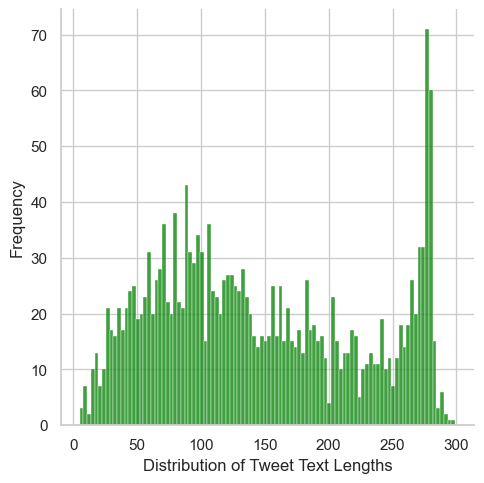

In [4]:
#adding an extra column as this is the columsn that will appear in the dataset we gave to LLM, we can of course adapt this 
# just depends which analysis we will be doing first 

df['cleaned_text'] = df['text']


# creating a new column containing the length of each headline text that is larger than 0
non_empty_lengths = df[(df['cleaned_text'].notnull()) & (df['display_text_width'] > 0)]['display_text_width']
# visualising the length distribution 

sns.set(rc={'figure.figsize':(14,11)})
sns.set(style="whitegrid")
sns.displot(non_empty_lengths, kde=False, color='green', bins=100)


plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Distribution of Tweet Text Lengths', fontsize=12)
plt.grid(True)


plt.show()

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectoriser = CountVectorizer(stop_words="english") # Stopwords for BERT

In [6]:
from TweetNormalizer import normalizeTweet

def apply_tweet_normalization(df):
    """
    Apply tweet normalization to the 'cleaned_text' column in the DataFrame.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing the 'cleaned_text' column.
        
    Returns:
        pandas.DataFrame: DataFrame with normalized tweet text.
    """
    try:
        df['cleaned_text'] = df['cleaned_text'].apply(normalizeTweet)
        return df
    except Exception as e:
        print("An error occurred:", e)
        return None

# Call the function to apply tweet normalization
df = apply_tweet_normalization(df)

In [7]:
df

,created_at_fuzzy,state_likely_tweeted_from,text,source,display_text_width,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,favourites_count,cleaned_text,Toxicity,Fact assessment,Trivia question,Offensive Assessment
0,2020-08-13T16:55:49Z,California,LIVE: Trump holds press conference https://t.c...,Twitter Web App,71,en,0,0,False,3281,4938,4,39349,23299,LIVE : Trump holds press conference HTTPURL vi...,1,no verdict,NaN,NaN
1,2020-08-30T00:03:31Z,Tennessee,Trump’s claim the ‘silent majority’ will save ...,Twitter Web App,205,en,9,2,False,2866,3000,2,23786,30906,Trump 's claim the ‘ silent majority ' will sa...,8,'no verdict',NaN,NaN
2,2020-10-26T23:16:05Z,New York,#NewHampshire #VoteBlue #VoteBlueToSaveAmerica...,Twitter Web App,267,en,7,4,False,32221,26550,52,304911,146137,#NewHampshire #VoteBlue #VoteBlueToSaveAmerica...,2,'true',NaN,NaN
3,2020-08-24T09:54:59Z,Florida,"@davidsirota I'm so confused, when is the medi...",Twitter for Android,262,en,2,0,False,457,375,5,16851,7429,"@USER I 'm so confused , when is the media goi...",7,'no verdict',NaN,NaN
4,2021-02-04T11:31:07Z,Washington,@Carlos27480217 @DonaldJTrumpJr Yep! He has Ba...,Twitter for Android,88,en,0,0,False,43,177,0,2618,1517,@USER @USER Yep ! He has Balls ! ! Now with Ou...,8,'false',NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2021-01-15T18:46:33Z,Georgia,U.S. says Capitol rioters meant to 'capture an...,Twitter for iPhone,126,en,2,0,False,1546,1600,2,5156,3058,U . S . says Capitol rioters meant to ' captur...,8,'true',NaN,NaN
1996,2020-12-21T13:11:53Z,Iowa,@KeithOlbermann Look in Keith’s eyes. Trump o...,Twitter for iPhone,104,en,0,0,False,28,50,0,758,6974,@USER Look in Keith 's eyes . Trump owns him ....,8,'no verdict',NaN,NaN
1997,2021-02-06T06:35:34Z,North Carolina,@AmyAThatcher I guess the right wingers are pi...,Twitter for Android,125,en,1,0,False,598,512,9,26537,156580,@USER I guess the right wingers are pissed bec...,3,'no verdict',NaN,NaN
1998,2020-08-14T07:37:59Z,Iowa,Insane....\r\n\r\nBiden calls for mandate requ...,Twitter for iPad,98,en,1,0,False,31,96,0,1041,2414,Insane ... Biden calls for mandate requiring a...,2,'true',NaN,NaN


In [8]:
def clean_text_BERT(doc):
    lemma = WordNetLemmatizer()
    no_emoji = emoji.demojize(doc, delimiters=("", "")) # Substitutes emoji by descriptive word
    normalized = " ".join(lemma.lemmatize(word).lower() for word in no_emoji.split())
    return normalized

df["cleaned_text"] = df["cleaned_text"].apply(clean_text_BERT)
df

,created_at_fuzzy,state_likely_tweeted_from,text,source,display_text_width,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,favourites_count,cleaned_text,Toxicity,Fact assessment,Trivia question,Offensive Assessment
0,2020-08-13T16:55:49Z,California,LIVE: Trump holds press conference https://t.c...,Twitter Web App,71,en,0,0,False,3281,4938,4,39349,23299,live : trump hold press conference httpurl via...,1,no verdict,NaN,NaN
1,2020-08-30T00:03:31Z,Tennessee,Trump’s claim the ‘silent majority’ will save ...,Twitter Web App,205,en,9,2,False,2866,3000,2,23786,30906,trump 's claim the ‘ silent majority ' will sa...,8,'no verdict',NaN,NaN
2,2020-10-26T23:16:05Z,New York,#NewHampshire #VoteBlue #VoteBlueToSaveAmerica...,Twitter Web App,267,en,7,4,False,32221,26550,52,304911,146137,#newhampshire #voteblue #votebluetosaveamerica...,2,'true',NaN,NaN
3,2020-08-24T09:54:59Z,Florida,"@davidsirota I'm so confused, when is the medi...",Twitter for Android,262,en,2,0,False,457,375,5,16851,7429,"@user i 'm so confused , when is the medium go...",7,'no verdict',NaN,NaN
4,2021-02-04T11:31:07Z,Washington,@Carlos27480217 @DonaldJTrumpJr Yep! He has Ba...,Twitter for Android,88,en,0,0,False,43,177,0,2618,1517,@user @user yep ! he ha balls ! ! now with our...,8,'false',NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2021-01-15T18:46:33Z,Georgia,U.S. says Capitol rioters meant to 'capture an...,Twitter for iPhone,126,en,2,0,False,1546,1600,2,5156,3058,u . s . say capitol rioter meant to ' capture ...,8,'true',NaN,NaN
1996,2020-12-21T13:11:53Z,Iowa,@KeithOlbermann Look in Keith’s eyes. Trump o...,Twitter for iPhone,104,en,0,0,False,28,50,0,758,6974,@user look in keith 's eye . trump owns him . ...,8,'no verdict',NaN,NaN
1997,2021-02-06T06:35:34Z,North Carolina,@AmyAThatcher I guess the right wingers are pi...,Twitter for Android,125,en,1,0,False,598,512,9,26537,156580,@user i guess the right winger are pissed beca...,3,'no verdict',NaN,NaN
1998,2020-08-14T07:37:59Z,Iowa,Insane....\r\n\r\nBiden calls for mandate requ...,Twitter for iPad,98,en,1,0,False,31,96,0,1041,2414,insane ... biden call for mandate requiring al...,2,'true',NaN,NaN


In [9]:
# import re
# from nltk.stem import WordNetLemmatizer

# def clean_text_BERT(doc):
#     # Define a regular expression pattern for emojis
#     emoji_pattern = re.compile("["
#         u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F700-\U0001F77F"  # alchemical symbols
#         u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
#         u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
#         u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
#         u"\U0001FA00-\U0001FA6F"  # Chess Symbols
#         u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
#         u"\U00002702-\U000027B0"  # Dingbats
#         u"\U000024C2-\U0001F251" 
#         "]+", flags=re.UNICODE)

#     # Remove emojis from the document
#     no_emoji = emoji_pattern.sub(r'', doc)

#     lemma = WordNetLemmatizer()
#     normalized = " ".join(lemma.lemmatize(word).lower() for word in no_emoji.split())
#     return normalized

# # Apply the updated function to the DataFrame
# df["cleaned_text"] = df["cleaned_text"].apply(clean_text_BERT)


In [10]:
def remove_specific_words(df):
    # Define the words to remove
    words_to_remove = ['@user', 'httpurl']
    
    # Create a regex pattern to match these words
    pattern = '|'.join(words_to_remove)
    
    try:
        # Replace the words with an empty string
        df['cleaned_text'] = df['cleaned_text'].str.replace(pattern, '', regex=True)
        return df
    except Exception as e:
        print("An error occurred while removing specific words:", e)
        return None

# Call the function to remove the words
df = remove_specific_words(df)

# Display the DataFrame to verify changes
print(df.head())

       created_at_fuzzy state_likely_tweeted_from  \
0  2020-08-13T16:55:49Z                California   
1  2020-08-30T00:03:31Z                 Tennessee   
2  2020-10-26T23:16:05Z                  New York   
3  2020-08-24T09:54:59Z                   Florida   
4  2021-02-04T11:31:07Z                Washington   

                                                text               source  \
0  LIVE: Trump holds press conference https://t.c...      Twitter Web App   
1  Trump’s claim the ‘silent majority’ will save ...      Twitter Web App   
2  #NewHampshire #VoteBlue #VoteBlueToSaveAmerica...      Twitter Web App   
3  @davidsirota I'm so confused, when is the medi...  Twitter for Android   
4  @Carlos27480217 @DonaldJTrumpJr Yep! He has Ba...  Twitter for Android   

   display_text_width lang  favorite_count  retweet_count  is_quote  \
0                  71   en               0              0     False   
1                 205   en               9              2     False   
2    

In [11]:
# # Function to dynamically add words with underscores to stop words
# def update_stop_words(texts, base_stop_words):
#     new_stop_words = set(base_stop_words)
#     for text in texts:
#         words = text.split()
#         new_stop_words.update(word for word in words if '_' in word)
#     return new_stop_words

In [12]:
def update_stop_words(texts, base_stop_words):
    new_stop_words = set(base_stop_words)
    for text in texts:
        # Splitting text into words
        words = text.split()
        # Adding words with underscores to the stop words, ensuring no colons are included
        new_stop_words.update(word.replace(':', '') for word in words if '_' in word)
    return new_stop_words


In [13]:
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from umap import UMAP
from bertopic.representation import KeyBERTInspired

print("all-MiniLM-L12-v2")

umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=42) 
representation_model = KeyBERTInspired()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# flag_hyperparameters 
# Specify min_cluster_size and min_samples to minimize outliers
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean',
                        cluster_selection_method='eom', prediction_data=True, min_samples=4) # Clustering algorithm that yields denser topics and reduces outliers

# Initiate BERTopic and fit data
model = BERTopic(verbose=True, representation_model = representation_model, 
                 embedding_model = "all-MiniLM-L12-v2", umap_model = umap_model, 
                 ctfidf_model=ctfidf_model, hdbscan_model=hdbscan_model)
topics, _ = model.fit_transform(df["cleaned_text"])

# Get the default set of English stop words from scikit-learn
default_stop_words = text.ENGLISH_STOP_WORDS

# Define custom stop words
custom_stop_words = {'@user', 'user', 'httpurl', 'said', 'money-mouth_face'}

# Combine the default stop words with custom stop words
combined_stop_words = default_stop_words.union(custom_stop_words)

# Update the combined stop words with words containing underscores
combined_stop_words_updated = update_stop_words(df["cleaned_text"], combined_stop_words)

# Convert the updated combined stop words from a set to a list
combined_stop_words_list = list(combined_stop_words_updated)

# Initialize the CountVectorizer with the combined set of stop words
# count_vectoriser = CountVectorizer(ngram_range=(1, 2), stop_words="english")

count_vectoriser = CountVectorizer(ngram_range=(1, 2), stop_words=combined_stop_words_list)

# count_vectoriser = CountVectorizer(stop_words=combined_stop_words_list)

model.update_topics(df["cleaned_text"], vectorizer_model=count_vectoriser)

display(model.get_topic_info())

all-MiniLM-L12-v2


Batches:   0%|          | 0/60 [00:00<?, ?it/s]

2024-05-28 11:46:10,918 - BERTopic - Transformed documents to Embeddings
2024-05-28 11:46:33,386 - BERTopic - Reduced dimensionality
2024-05-28 11:46:33,562 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name,Representation,Representative_Docs
0,-1,711,-1_trump_biden_wa_president,"[trump, biden, wa, president, joe, ha, just, l...","[less than a week to go . biden is no prize , ..."
1,0,89,0_capitol_trump_terrorist_riot,"[capitol, trump, terrorist, riot, people, viol...",[ we 're interpreters & workers for u . s forc...
2,1,79,1_trump_wa_feel_love,"[trump, wa, feel, love, day, eyes, biden, hair...",[ ...
3,2,69,2_vote_ballot_state_election,"[vote, ballot, state, election, trump, mail, v...",[ if people who claim fraud get thei...
4,3,65,3_biden_vote biden_manifest_vote,"[biden, vote biden, manifest, vote, 45 elector...",[ seriously ? almost every poll sited on the ...
5,4,61,4_biden_plan_policy_tax,"[biden, plan, policy, tax, student, debt, admi...",[ criticism him relentlessly on populist poli...
6,5,57,5_supporter_trump supporter_support_trump,"[supporter, trump supporter, support, trump, s...",[ this is fair but generous . he 's also gett...
7,6,54,6_money_trump_economy_tax,"[money, trump, economy, tax, year, like, econo...",[ i support no tax on truly family farms but g...
8,7,47,7_trump_world_trump trump_real,"[trump, world, trump trump, real, country, pan...",[ trump ha been a laughing stock to the enti...
9,8,44,8_trump_think_term_crazy,"[trump, think, term, crazy, office, like trump...",[ people that think trump wa anything other th...


In [14]:
# Dictionary mapping the topic numbers with the new names
new_topic_names = {
    0: "Capitol Riot",
    1: "Personal Sentiments",
    2: "Voting Process",
    3: "Election Legitimacy",
    4: "Economic Policy",
    5: "Political Support",
    6: "Financial Discussions",
    7: "Global Affairs",
    8: "General Opinion",
    9: "Social Media Discourse",
    10: "Kamala Harris",
    11: "Public Perception",
    12: "COVID-19 Vaccine",
    13: "Judicial System",
    14: "Immigration",
    15: "Political Critique",
    16: "Racial Issues",
    17: "Media Coverage",
    18: "Election Concession",
    19: "Election Results",
    20: "Russian Influence",
    21: "Religious Discussion",
    22: "Deception",
    23: "China Relations",
    24: "Gun Control",
    25: "Domestic Disturbances",
    26: "Impeachment Talks",
    27: "Legislative Issues",
    28: "Economic Criticism",
    29: "Financial Mismanagement",
    30: "Political Debates",
    31: "Cultural References",
    32: "Pence's Role",
    33: "Health Concerns",
    34: "Criminal Justice",
    35: "Social Issues",
    36: "Pandemic Response",
    37: "Digital Platforms",
    38: "Mask Wearing",
    39: "COVID-19 Impact"
}

# Rename topics
model.rename_topics(new_topic_names)

# Optionally, you might want to see the updated topic names
print(model.get_topic_info())


AttributeError: 'BERTopic' object has no attribute 'rename_topics'

In [15]:
model.visualize_topics(custom_labels=True)

In [16]:
model.visualize_barchart(custom_labels=True, top_n_topics=43)

## Visualisation of word distribution

In [17]:
model.visualize_term_rank()


# Modelling

In [18]:
df['topic_label'] = topics

# Save the DataFrame with the new column
df.to_csv('dataset_with_topic_labels.csv', index=False)

### Topic visualisation


In [19]:
model.visualize_hierarchy(top_n_topics=43)

In [20]:
#saving the model
model.save("bert_best_model_tweets")

# loading the serialised model
my_best_model = BERTopic.load("bert_best_model_tweets")
my_best_model